In [1]:
import dlc_practical_prologue as plg
from torch import nn, LongTensor
from torch.nn import functional as F
import torch

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nb_hidden = 100
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.fc1 = nn.Linear(16 * 6 * 6, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.fc1(x.view(-1, 16 * 6 * 6))
        x = self.fc2(x)
        return x

In [2]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(2 * 2 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [3]:
N = 5000
train_input, train_target, train_classes, test_input, test_target, test_classes = plg.generate_pair_sets(N)

In [4]:
train_input_left = train_input[:,0,:,:].view(N,1,14,14)
train_classes_left = plg.convert_to_one_hot_labels(train_input, train_classes[:,0]).type(LongTensor)
test_input_left = test_input[:,0,:,:].view(N,1,14,14)
test_classes_left = plg.convert_to_one_hot_labels(test_input, test_classes[:,0]).type(LongTensor)

In [5]:
def train_model(model, train_input, train_target, mini_batch_size):
    
    if (torch.cuda.is_available()):
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
        
    model.to(device)
    train_input = train_input.to(device)
    train_target = train_target.to(device)
    
    criterion = nn.CrossEntropyLoss().to(device)
    #criterion = nn.MSELoss().to(device)
    eta = 1e-1
    epochs = 50
    optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    
    for e in range(0, epochs):
        for input_data, target_data in zip(train_input.split(mini_batch_size), train_target.split(mini_batch_size)):
            output = model(input_data)
            loss = criterion(output, target_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [6]:
def compute_nb_errors_one_hot(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        act_classes = target.narrow(0, b, mini_batch_size).max(1)[1]
        for k in range(mini_batch_size):
            if act_classes[k] != predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

In [7]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[k] != predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

In [8]:
model = Net2()
train_model(model, train_input_left, train_classes[:,0], 100)

In [9]:
compute_nb_errors(model, test_input_left, test_classes[:,0], 100)

4401

In [10]:
compute_nb_errors(model, train_input_left, train_classes[:,0], 100)

4454

In [15]:
(model(train_input_left).max(1)[1] - train_classes[:,0]).sum()

tensor(-186)

In [9]:
import matplotlib.pyplot as plt

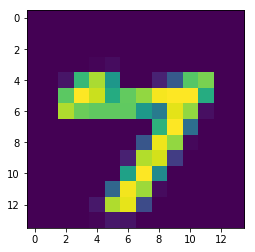

In [10]:
plt.imshow(train_input_left[2000,0,:,:])
plt.show()